In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pymoo.decomposition.asf import ASF
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.optimization.saver import load_checkpoint
from auto_robot_design.description.builder import jps_graph2pinocchio_robot

In [2]:
import tkinter as tk
from tkinter import filedialog

def select_directory():
    # Create a root window
    root = tk.Tk()
    # Hide the root window
    root.withdraw()
    # Make the root window the topmost window
    root.call('wm', 'attributes', '.', '-topmost', True)
    # Open directory dialog and store the selected directory path
    directory_path = filedialog.askdirectory(initialdir="./",
        title="Select a directory"
    )
    root.update_idletasks() 
    root.destroy()
    # Check if a directory was selected
    if directory_path:
        #print(f"Selected directory: {directory_path}")
        return directory_path
    else:
        #print("No directory selected")
        return None

# Call the function to open the directory dialog
selected_directory = select_directory()
print(f"Resulting directory path: {selected_directory}")

Resulting directory path: /home/be2r-lab-210134/Python/auto-robotics-diesign/auto-robotics-design/apps/optimize/results/first_setup/topology_7_2024-07-12_13-29-43


In [3]:
problem = MultiCriteriaProblem.load(
    selected_directory
)

checkpoint = load_checkpoint(selected_directory)
optimizer = PymooOptimizer(problem, checkpoint)
optimizer.load_history(selected_directory)
res = optimizer.run()

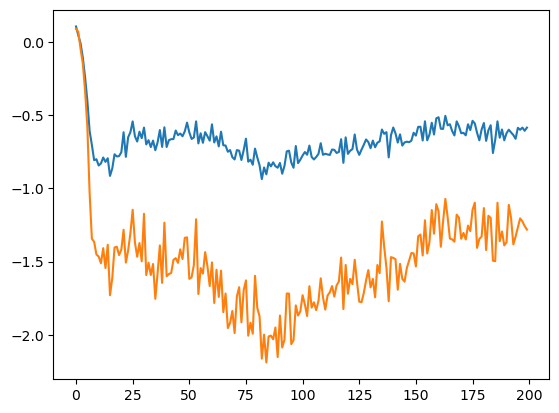

In [4]:
history_mean = optimizer.history["Mean"]
plt.plot(np.arange(len(history_mean)), history_mean)
plt.show()


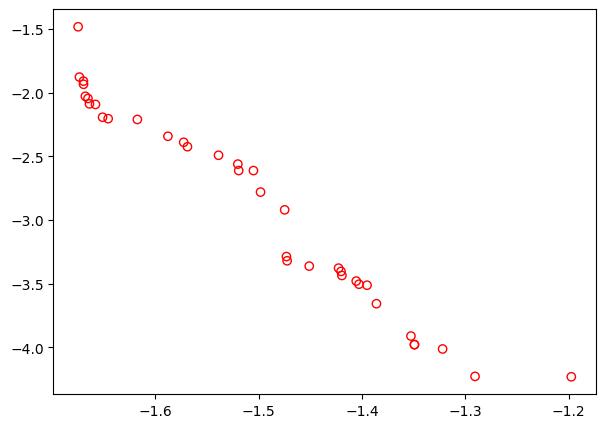

In [5]:
F = res.F
xl, xu = problem.bounds()
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, )
ax.scatter(F[:, 0], F[:, 1],  facecolors='none', edgecolors='r')

In [6]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)


Scale f1: [-1.6747581958770752, -1.1972847779591878]
Scale f2: [-4.231493915522488, -1.4815105712665215]


Best regarding ASF: 
F = [-1.45101039 -3.36199621]


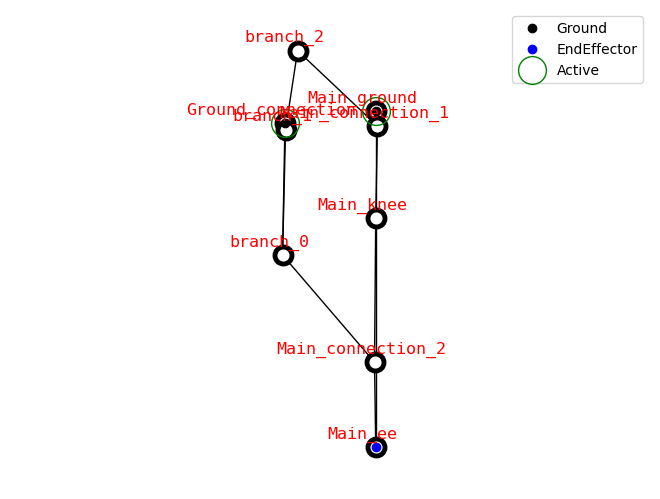

In [7]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.4, 0.6])

decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]
print(f"Best regarding ASF: \nF = {F[b]}")
graph = problem.graph_manager.get_graph(best_x)
draw_joint_point(graph)

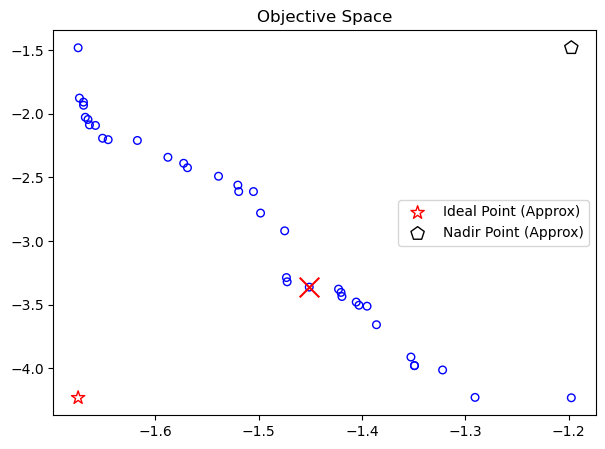

In [8]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.scatter(F[b, 0], F[b, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.legend()
plt.show()

In [9]:
histF = np.array(optimizer.history["F"])
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 0.564609375


In [10]:
worstF1_id = np.argmax(validF1)
worstF2_id = np.argmax(validF2)
worst_reward2 = validF2[worstF2_id]
worst_reward1 = validF1[worstF1_id]
print('The maximum result in optimization task:', worst_reward1, worst_reward2)

The maximum result in optimization task: -0.5261307458082835 -0.28326946849005474


In [11]:
bestF1_id = np.argmin(validF1)
bestF2_id = np.argmin(validF2)
bestF1_x = optimizer.history["X"][np.where(histF[:,0]==validF1[bestF1_id])[0][0]]
bestF1_reward = validF1[bestF1_id]
bestF2_x = optimizer.history["X"][np.where(histF[:,1]==validF2[bestF2_id])[0][0]]
bestF2_reward = validF2[bestF2_id]
print("The minimum result in optimization task: F1:", bestF1_reward, " F2: ", bestF2_reward, f" F: weights: {weights}", F[b])

The minimum result in optimization task: F1: -1.6747581958770752  F2:  -4.231493915522488  F: weights: [0.4 0.6] [-1.45101039 -3.36199621]


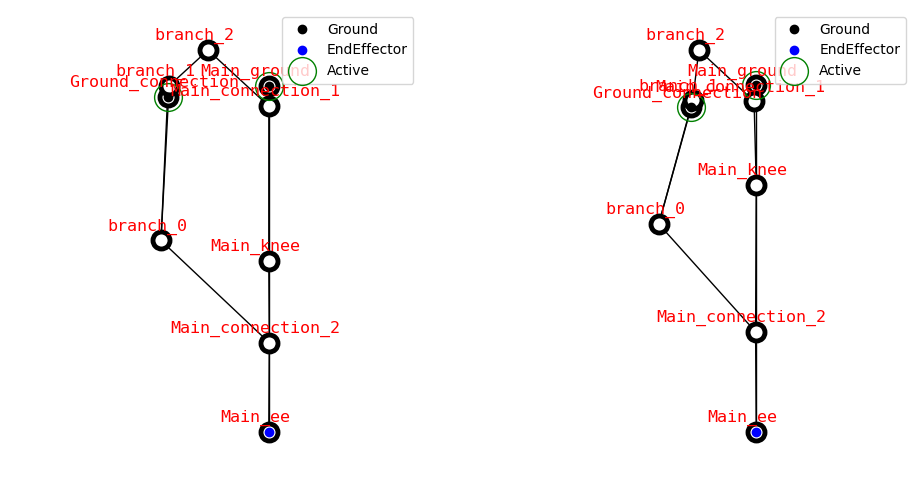

In [12]:
gm = problem.graph_manager
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
graph = gm.get_graph(bestF1_x)
draw_joint_point(graph)
plt.subplot(1, 3, 2)
graph = gm.get_graph(bestF2_x)
draw_joint_point(graph)


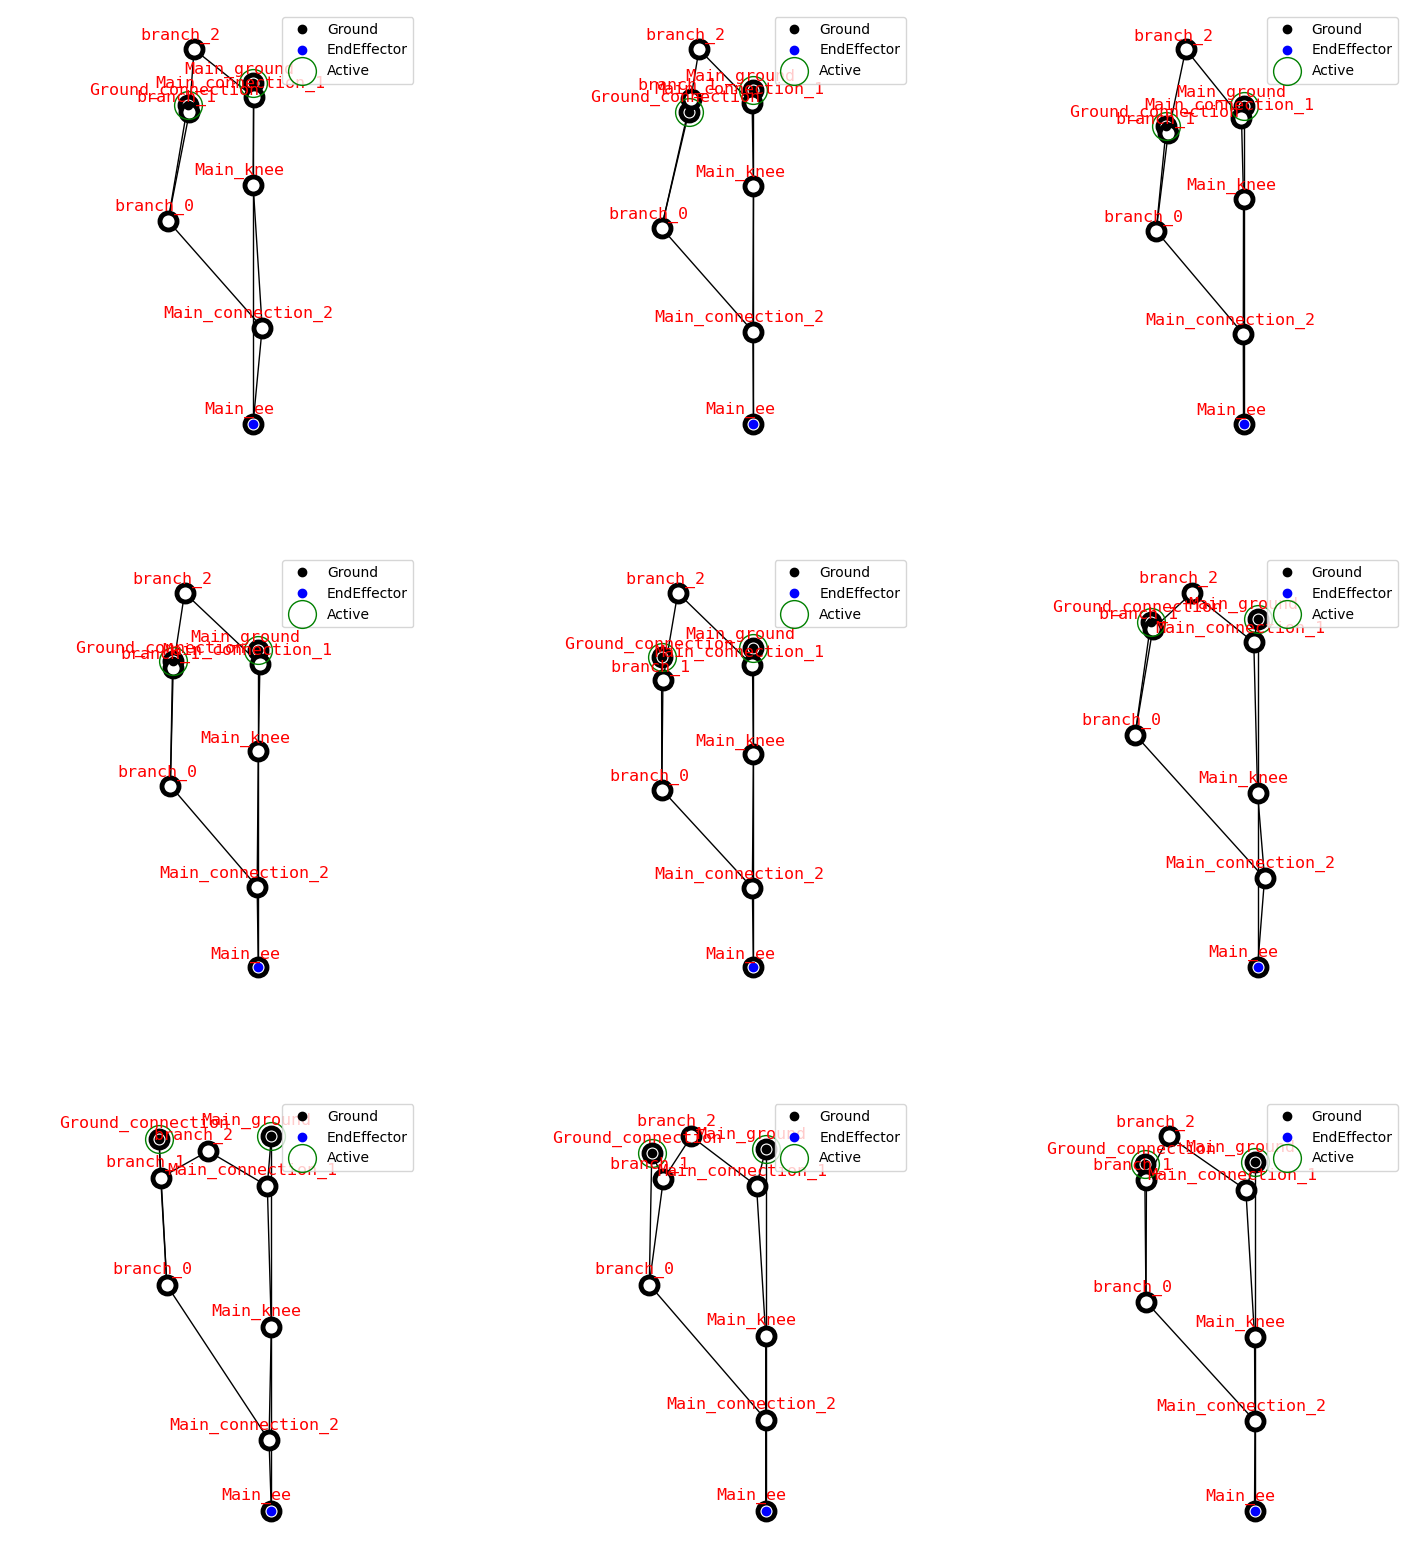

In [13]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
decomp = ASF()
weights_vector = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(18, 20))
for i, w in enumerate(weights_vector):
    weights = np.array([w, 1-w])
    b = decomp.do(nF, 1/weights).argmin()
    best_x = res.X[b]
    graph = problem.graph_manager.get_graph(best_x)
    plt.subplot(3, 3, i+1)
    draw_joint_point(graph)

plt.show()

In [14]:
histF = res.F
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 1.0


In [15]:
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability

ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.075, 0, 50))

left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, -0.09, 50))

right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, 0.09, 50))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
sf = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
                                                                                   ground_symmetric_step2,
                                                                                   ground_symmetric_step3,
                                                                                   central_vertical,
                                                                                   left_vertical,
                                                                                   right_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

In [16]:

# sf = problem.soft_constrain
# builder = problem.builder
# crag = problem.rewards_and_trajectories.crag
# trajectory = problem.rewards_and_trajectories.trajectories[1]

counter = 0
for i, x in enumerate(res.X):
    #x= np.round(x, 5)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter += 1
    else:
        __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
        print(res.F[i], vector_rewards)
counter

[-1.66522086 -2.04483438] [1.665220856666565, 2.0448343778336153]
[-1.47239478 -3.3202241 ] [1.4723947842915852, 3.320224100861575]
5e-07
[-1.40551134 -3.47949967] [1.1362869342168171, 2.6015736805813865]
[-1.47479757 -2.9198067 ] [1.4330211480458577, 2.6427461780959485]
6.153718418545193e-07
[-1.47309228 -3.28695847] [1.4730922778447468, 3.286958474154396]
[-1.65109869 -2.19222402] [1.6510987281799316, 2.192224023939186]
[-1.50502475 -2.6111995 ] [1.5050246715545654, 2.6111994993097993]
[-1.45101039 -3.36199621] [1.4510103861490886, 3.361996214940792]
[-1.53883493 -2.49089846] [1.5388348897298176, 2.490898458092761]
[-1.66380401 -2.08719118] [1.663804014523824, 2.087191181151183]
[-1.38593586 -3.65749246] [1.1722615957260132, 3.2097927765915]
[-1.66951295 -1.93327065] [1.669512947400411, 1.9332706507493895]
1.6787823571099175e-07
1.3546909332275388e-06
[-1.42023365 -3.40377671] [1.2554027636845906, 3.2038373287582]
[-1.42262717 -3.37784237] [1.3205329577128093, 3.125685596411678]
[-1.

9

In [17]:
F = np.array(optimizer.history["F"])
X = np.array(optimizer.history["X"])
Fs = np.array(optimizer.history["Fs"])
idx=np.where(F[:,0]==res.F[0][0])[0][0]
idx

12303

In [18]:
x = X[idx]
x

array([-0.12595653, -0.01241096, -0.20213146,  0.02066998,  0.36933587,
       -0.00315732,  0.02043175, -0.13332755,  0.12390619,  0.00180337,
       -0.01673276, -0.08820323,  0.08690153])

In [19]:
Fs[idx]

array([1.64965439, 1.66717529, 1.67883289, 1.5215594 , 2.12761592,
       2.48532781])

In [20]:
#x = np.round(X[idx],5)
print(x)
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
#point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

if constrain_error>0:
    print(constrain_error)
    counter+=1
#else:
__, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
print(F[idx], vector_rewards, '\n', partial_rewards)

[-0.12595653 -0.01241096 -0.20213146  0.02066998  0.36933587 -0.00315732
  0.02043175 -0.13332755  0.12390619  0.00180337 -0.01673276 -0.08820323
  0.08690153]
[-1.66522086 -2.04483438] [1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]


In [21]:
for i in range(3,8):    
    x = np.round(X[idx],i)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

3.601259973314073e-07
[1.3821036020914714, 1.627434754294273] 
 [1.6496027, 1.6671011, 0.829607, 0.27286503955978886, 2.12617290753529, 2.48326631578774]
2.684325536092122e-07
[1.308476169904073, 1.4432022852928437] 
 [0.7644651, 1.6670897, 1.4938737, 0.8008432507186573, 2.1287422220683276, 1.400021383091546]
[1.6644642353057861, 1.682900211624759] 
 [1.6496526, 1.6671686, 1.6765715, 1.5216144666167786, 2.127822684604447, 1.399263483653051]
4.533988316853841e-07
[1.0854719479878743, 2.044846195172431] 
 [0.7637569, 1.6671754, 0.82548356, 1.521565002303382, 2.127633320143663, 2.485340263070247]
[1.6652209361394246, 2.0448335669229833] 
 [1.6496545, 1.6671753, 1.678833, 1.5215593689929496, 2.1276151216325445, 2.485326210143455]


In [22]:
import random 
for i in range(8): 
    np.random.seed = i
    random.seed = i
    x = X[idx]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

for i in range(8): 
    np.random.seed = i
    random.seed = i
    x = X[idx]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1

In [23]:
import random 
for i in range(8): 
    np.random.seed = i
    random.seed = i
    x = X[idx]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1.6671753, 1.6788329, 1.5215594031269102, 2.1276159226529177, 2.485327807721018]
[1.665220856666565, 2.0448343778336153] 
 [1.6496544, 1

In [24]:
Fs[idx]

array([1.64965439, 1.66717529, 1.67883289, 1.5215594 , 2.12761592,
       2.48532781])

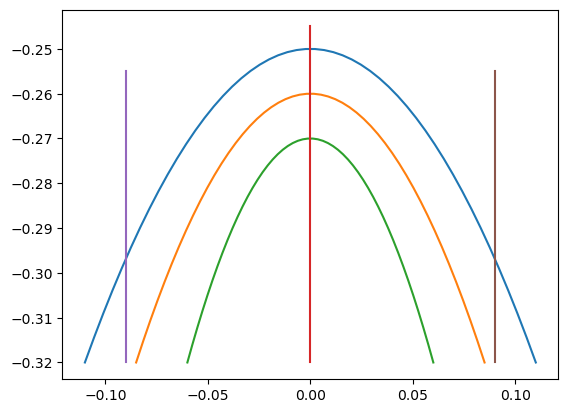

In [25]:
for _, trajectory in problem.rewards_and_trajectories.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])


plt.show()

In [30]:
from auto_robot_design.pinokla.criterion_agregator import calculate_quasi_static_simdata
from pinocchio.visualize import MeshcatVisualizer
import meshcat
trajectory = problem.rewards_and_trajectories.trajectories[5]
x= np.round(X[idx],6)
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
crag.get_criteria_data(fixed_robot, free_robot, trajectory,viz)
#calculate_quasi_static_simdata(free_robot, fixed_robot,'EE', trajectory, viz=viz)
pass

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
